# Análisis Matemático para Inteligencia Artificial - CEIA Coh17 (UBA)

Integrantes:

Agustín de la Vega (delavega.agus@gmail.com)

Florentino Arias (florito.arias@gmail.com)

Agustina Quiros (agustinaqr@gmail.com)

Matías Cardozo Pittana (cardozo.matiasp@gmail.com)

Paola Cartalá (paola.cartala@gmail.com)

# Trabajo Práctico Final: Linear/Quadratic Discriminant Analysis (LDA/QDA)

### Definición: Clasificador Bayesiano

Sean $k$ poblaciones, $x \in \mathbb{R}^p$ puede pertenecer a cualquiera $g \in \mathcal{G}$ de ellas. Bajo un esquema bayesiano, se define entonces $\pi_j \doteq P(G = j)$ la probabilidad *a priori* de que $X$ pertenezca a la clase *j*, y se **asume conocida** la distribución condicional de cada observable dado su clase $f_j \doteq f_{X|G=j}$.

De esta manera dicha probabilidad *a posteriori* resulta
$$
P(G|_{X=x} = j) = \frac{f_{X|G=j}(x) \cdot p_G(j)}{f_X(x)} \propto f_j(x) \cdot \pi_j
$$

La regla de decisión de Bayes es entonces
$$
H(x) \doteq \arg \max_{g \in \mathcal{G}} \{ P(G|_{X=x} = j) \} = \arg \max_{g \in \mathcal{G}} \{ f_j(x) \cdot \pi_j \}
$$

es decir, se predice a $x$ como perteneciente a la población $j$ cuya probabilidad a posteriori es máxima.

*Ojo, a no desesperar! $\pi_j$ no es otra cosa que una constante prefijada, y $f_j$ es, en su esencia, un campo escalar de $x$ a simplemente evaluar.*

### Distribución condicional

Para los clasificadores de discriminante cuadrático y lineal (QDA/LDA) se asume que $X|_{G=j} \sim \mathcal{N}_p(\mu_j, \Sigma_j)$, es decir, se asume que cada población sigue una distribución normal.

Por definición, se tiene entonces que para una clase $j$:
$$
f_j(x) = \frac{1}{(2 \pi)^\frac{p}{2} \cdot |\Sigma_j|^\frac{1}{2}} e^{- \frac{1}{2}(x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j)}
$$

Aplicando logaritmo (que al ser una función estrictamente creciente no afecta el cálculo de máximos/mínimos), queda algo mucho más práctico de trabajar:

$$
\log{f_j(x)} = -\frac{1}{2}\log |\Sigma_j| - \frac{1}{2} (x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j) + C
$$

Observar que en este caso $C=-\frac{p}{2} \log(2\pi)$, pero no se tiene en cuenta ya que al tener una constante aditiva en todas las clases, no afecta al cálculo del máximo.

### LDA

En el caso de LDA se hace una suposición extra, que es $X|_{G=j} \sim \mathcal{N}_p(\mu_j, \Sigma)$, es decir que las poblaciones no sólo siguen una distribución normal sino que son de igual matriz de covarianzas. Reemplazando arriba se obtiene entonces:

$$
\log{f_j(x)} =  -\frac{1}{2}\log |\Sigma| - \frac{1}{2} (x-\mu_j)^T \Sigma^{-1} (x- \mu_j) + C
$$

Ahora, como $-\frac{1}{2}\log |\Sigma|$ es común a todas las clases se puede incorporar a la constante aditiva y, distribuyendo y reagrupando términos sobre $(x-\mu_j)^T \Sigma^{-1} (x- \mu_j)$ se obtiene finalmente:

$$
\log{f_j(x)} =  \mu_j^T \Sigma^{-1} (x- \frac{1}{2} \mu_j) + C'
$$

### Entrenamiento/Ajuste

Obsérvese que para ambos modelos, ajustarlos a los datos implica estimar los parámetros $(\mu_j, \Sigma_j) \; \forall j = 1, \dots, k$ en el caso de QDA, y $(\mu_j, \Sigma)$ para LDA.

Estos parámetros se estiman por máxima verosimilitud, de manera que los estimadores resultan:

* $\hat{\mu}_j = \bar{x}_j$ el promedio de los $x$ de la clase *j*
* $\hat{\Sigma}_j = s^2_j$ la matriz de covarianzas estimada para cada clase *j*
* $\hat{\pi}_j = f_{R_j} = \frac{n_j}{n}$ la frecuencia relativa de la clase *j* en la muestra
* $\hat{\Sigma} = \frac{1}{n} \sum_{j=1}^k n_j \cdot s^2_j$ el promedio ponderado (por frecs. relativas) de las matrices de covarianzas de todas las clases. *Observar que se utiliza el estimador de MV y no el insesgado*

Es importante notar que si bien todos los $\mu, \Sigma$ deben ser estimados, la distribución *a priori* puede no inferirse de los datos sino asumirse previamente, utilizándose como entrada del modelo.

### Predicción

Para estos modelos, al igual que para cualquier clasificador Bayesiano del tipo antes visto, la estimación de la clase es por método *plug-in* sobre la regla de decisión $H(x)$, es decir devolver la clase que maximiza $\hat{f}_j(x) \cdot \hat{\pi}_j$, o lo que es lo mismo $\log\hat{f}_j(x) + \log\hat{\pi}_j$.

## Estructura del código

## Modelo

In [ ]:
import numpy as np
from numpy.linalg import det, inv

In [ ]:
class ClassEncoder:
  def fit(self, y):
    self.names = np.unique(y)
    self.name_to_class = {name:idx for idx, name in enumerate(self.names)}
    self.fmt = y.dtype
    # Q1: por que no hace falta definir un class_to_name para el mapeo inverso? (se puede hacer mapeo de idx a name con self.names[idx])

  # Apply function f to matrix arr (flat to apply, then reshape)
  def _map_reshape(self, f, arr):
    return np.array([f(elem) for elem in arr.flatten()]).reshape(arr.shape)
    # Q2: por que hace falta un reshape?

  # Apply map_reshape to each item in matrix y, transforming all names to classes indexes
  def transform(self, y):
    return self._map_reshape(lambda name: self.name_to_class[name], y)

  def fit_transform(self, y):
    self.fit(y)
    return self.transform(y)

  # convert y_hat matrix to all tag names instead of indexes
  def detransform(self, y_hat):
    return self._map_reshape(lambda idx: self.names[idx], y_hat)

In [ ]:
class BaseBayesianClassifier:
  def __init__(self):
    self.encoder = ClassEncoder()

  def _estimate_a_priori(self, y):
    a_priori = np.bincount(y.flatten().astype(int)) / y.size # array where each idx is the probability of that class in the given array
    # Q3: para que sirve bincount?
    return np.log(a_priori)

  def _fit_params(self, X, y):
    # estimate all needed parameters for given model
    raise NotImplementedError()

  def _predict_log_conditional(self, x, class_idx):
    # predict the log(P(x|G=class_idx)), the log of the conditional probability of x given the class
    # this should depend on the model used
    raise NotImplementedError()

  def fit(self, X, y, a_priori=None):
    # first encode the classes
    y = self.encoder.fit_transform(y)

    # if it's needed, estimate a priori probabilities (probability per index)
    self.log_a_priori = self._estimate_a_priori(y) if a_priori is None else np.log(a_priori)

    # check that a_priori has the correct number of classes
    assert len(self.log_a_priori) == len(self.encoder.names), "A priori probabilities do not match number of classes"

    # now that everything else is in place, estimate all needed parameters for given model (covariance matrix, means, etc)
    self._fit_params(X, y)
    # Q4: por que el _fit_params va al final? no se puede mover a, por ejemplo, antes de la priori? (cov matrix needs a_priori calculations and encoded classes)

  def predict(self, X):
    # this is actually an individual prediction encased in a for-loop
    m_obs = X.shape[1]
    y_hat = np.empty(m_obs, dtype=self.encoder.fmt)

    for i in range(m_obs):
      encoded_y_hat_i = self._predict_one(X[:,i].reshape(-1,1))
      y_hat[i] = self.encoder.names[encoded_y_hat_i]

    # return prediction as a row vector (matching y)
    return y_hat.reshape(1,-1)

  def _predict_one(self, x):
    # calculate all log posteriori probabilities (actually, +C)
    log_posteriori = [ log_a_priori_i + self._predict_log_conditional(x, idx) for idx, log_a_priori_i
                  in enumerate(self.log_a_priori) ]

    # return the class that has maximum a posteriori probability
    return np.argmax(log_posteriori)

In [ ]:
class QDA(BaseBayesianClassifier):

  def _fit_params(self, X, y):
    # estimate each covariance matrix
    # Calculate inverted cov matrix for each class (idx)
    self.inv_covs = [inv(np.cov(X[:,y.flatten()==idx], bias=True))
                      for idx in range(len(self.log_a_priori))]
    # Q5: por que hace falta el flatten y no se puede directamente X[:,y==idx]?
    # Q6: por que se usa bias=True en vez del default bias=False?
    # y.flatten() = idx[]
    # len a_priori = amount of classes
    # X[:,y.flatten()==idx] => all rows (features) which belongs to the current idx class
    self.means = [X[:,y.flatten()==idx].mean(axis=1, keepdims=True)
                  for idx in range(len(self.log_a_priori))]
    # Q7: que hace axis=1? por que no axis=0?

  def _predict_log_conditional(self, x, class_idx):
    # predict the log(P(x|G=class_idx)), the log of the conditional probability of x given the class
    # this should depend on the model used
    inv_cov = self.inv_covs[class_idx]
    unbiased_x =  x - self.means[class_idx]
    return 0.5*np.log(det(inv_cov)) -0.5 * unbiased_x.T @ inv_cov @ unbiased_x

In [ ]:
class TensorizedQDA(QDA):

    def _fit_params(self, X, y):
        # ask plain QDA to fit params
        super()._fit_params(X,y)

        # stack onto new dimension
        self.tensor_inv_cov = np.stack(self.inv_covs)
        self.tensor_means = np.stack(self.means)

    def _predict_log_conditionals(self,x):
        unbiased_x = x - self.tensor_means
        inner_prod = unbiased_x.transpose(0,2,1) @ self.tensor_inv_cov @ unbiased_x

        return 0.5*np.log(det(self.tensor_inv_cov)) - 0.5 * inner_prod.flatten()

    def _predict_one(self, x):
        # return the class that has maximum a posteriori probability
        return np.argmax(self.log_a_priori + self._predict_log_conditionals(x))

## Código para pruebas

Seteamos los datos

In [ ]:
# hiperparámetros
rng_seed = 6543

In [ ]:
from sklearn.datasets import load_iris, fetch_openml

def get_iris_dataset():
  data = load_iris()
  X_full = data.data
  y_full = np.array([data.target_names[y] for y in data.target.reshape(-1,1)])
  return X_full, y_full

def get_penguins():
    # get data
    df, tgt = fetch_openml(name="penguins", return_X_y=True, as_frame=True, parser='auto')

    # drop non-numeric columns
    df.drop(columns=["island","sex"], inplace=True)

    # drop rows with missing values
    mask = df.isna().sum(axis=1) == 0
    df = df[mask]
    tgt = tgt[mask]

    return df.values, tgt.to_numpy().reshape(-1,1)

# showing for iris
X_full, y_full = get_iris_dataset()

print(f"X: {X_full.shape}, Y:{y_full.shape}")

X: (150, 4), Y:(150, 1)


In [ ]:
# peek data matrix
X_full[:5]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

In [ ]:
# peek target vector
y_full[:5]

array([['setosa'],
       ['setosa'],
       ['setosa'],
       ['setosa'],
       ['setosa']], dtype='<U10')

Separamos el dataset en train y test para medir performance

In [ ]:
# preparing data, train - test validation
# 70-30 split
from sklearn.model_selection import train_test_split

def split_transpose(X, y, test_sz, random_state):
    # split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=random_state)

    # transpose so observations are column vectors
    return X_train.T, y_train.T, X_test.T, y_test.T

def accuracy(y_true, y_pred):
  return (y_true == y_pred).mean()

train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.4, rng_seed)

print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(4, 90) (1, 90) (4, 60) (1, 60)


Entrenamos un QDA y medimos su accuracy

In [ ]:
qda = QDA()

qda.fit(train_x, train_y)

In [ ]:
train_acc = accuracy(train_y, qda.predict(train_x))
test_acc = accuracy(test_y, qda.predict(test_x))
print(f"Train (apparent) error is {1-train_acc:.4f} while test error is {1-test_acc:.4f}")

Train (apparent) error is 0.0111 while test error is 0.0167


Con el magic %%timeit podemos estimar el tiempo que tarda en correr una celda en base a varias ejecuciones. Por poner un ejemplo, acá vamos a estimar lo que tarda un ciclo completo de QDA y también su inferencia (predicción).

Ojo! a veces [puede ser necesario ejecutarlo varias veces](https://stackoverflow.com/questions/10994405/python-timeit-results-cached-instead-of-calculated) para obtener resultados consistentes.

Si quieren explorar otros métodos de medición también es válido!

In [ ]:
%%timeit

qda.predict(test_x)

6.27 ms ± 1.17 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%%timeit

model = QDA()
model.fit(train_x, train_y)
model.predict(test_x)

10.7 ms ± 3.25 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Consigna


## Implementación base
1. Entrenar un modelo QDA sobre el dataset *iris* utilizando las distribuciones *a priori* a continuación ¿Se observan diferencias?¿Por qué cree? _Pista: comparar con las distribuciones del dataset completo, **sin splitear**_.
    1. Uniforme (cada clase tiene probabilidad 1/3)
    2. Una clase con probabilidad 0.9, las demás 0.05 (probar las 3 combinaciones)
2. Repetir el punto anterior para el dataset *penguin*.
3. Implementar el modelo LDA, entrenarlo y testearlo contra los mismos sets que QDA (no múltiples prioris) ¿Se observan diferencias? ¿Podría decirse que alguno de los dos es notoriamente mejor que el otro?
4. Utilizar otros 2 (dos) valores de *random seed* para obtener distintos splits de train y test, y repetir la comparación del punto anterior ¿Las conclusiones previas se mantienen?
5. Estimar y comparar los tiempos de predicción de las clases `QDA` y `TensorizedQDA`. De haber diferencias ¿Cuáles pueden ser las causas?


**Sugerencia:** puede resultar de utilidad para cada inciso de comparación utilizar tablas del siguiente estilo:

<center>

Modelo | Dataset | Seed | Error (train) | Error (test)
:---: | :---: | :---: | :---: | :---:
QDA | Iris | 125 | 0.55 | 0.85
LDA | Iris | 125 | 0.22 | 0.8

</center>


### 1. Entrenamiento QDA con diferentes *a_priori*

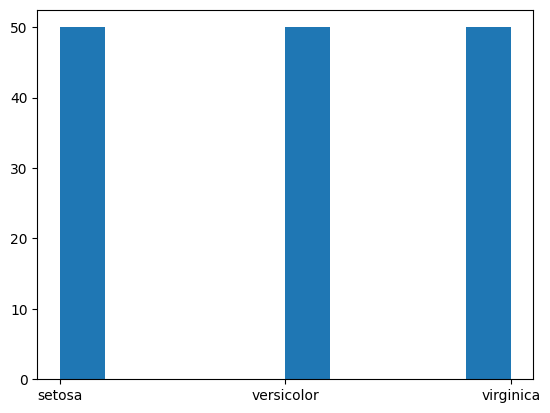

In [ ]:
import matplotlib.pyplot as plt

plt.hist(y_full.flatten())
plt.show()

In [ ]:
rng_seed = 123
train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.7, rng_seed)

a_prioris = [[1/3, 1/3, 1/3], [0.9, 0.05, 0.05], [0.05, 0.9, 0.05], [0.05, 0.05, 0.9]]
for i, a_priori in enumerate(a_prioris):
  qda = QDA()
  qda.fit(train_x, train_y, a_priori=a_priori)
  train_acc = accuracy(train_y, qda.predict(train_x))
  test_acc = accuracy(test_y, qda.predict(test_x))
  print(f"Using a_priori= {a_priori}")
  print(f"Train (apparent) error is {1-train_acc:.4f} while test error is {1-test_acc:.4f}")

Using a_priori= [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
Train (apparent) error is 0.0222 while test error is 0.0167
Using a_priori= [0.9, 0.05, 0.05]
Train (apparent) error is 0.0222 while test error is 0.0167
Using a_priori= [0.05, 0.9, 0.05]
Train (apparent) error is 0.0333 while test error is 0.0667
Using a_priori= [0.05, 0.05, 0.9]
Train (apparent) error is 0.0556 while test error is 0.0167


<center>

Modelo | Dataset | Seed | a_priori | Error (train) | Error (test)
:---: | :---: | :---: | :---: | :---: | :---:
QDA | Iris | 123 | [1/3, 1/3, 1/3] | **0.0222** | **0.0167**
QDA | Iris | 123 | [**0.9**, 0.05, 0.05] | **0.0222** | **0.0167**
QDA | Iris | 123 | [0.05, **0.9**, 0.05] | 0.0333 | 0.0667
QDA | Iris | 123 | [0.05, 0.05, **0.9**] | 0.0556 | 0.0167

</center>


Código para predict_one
log_posteriori = **log_a_priori_i** + **self._predict_log_conditional(x, class_idx)**

Corriendo con a_priori = [0.9, 0.05, 0.05]

class_0
log_a_priori_i = -0.11
_predict_log_conditional = **5.37**

class_1
log_a_priori_i = -2.996
_predict_log_conditional = -47.31

class_2
log_a_priori_i = -2.996
_predict_log_conditional = -74.88


_predict_log_conditional >> log_a_priori_n


Distribución que mejor debería performar es la 1/3 uniforme, acorde a la distribución del ds original. ...por qué segunda distribución no cambia el resultado?

La probabilidad a_priori de la primera clase no está afectando al resultado.

El valor de predict_log_conditional es tan grande que, independientemente del valor que tome a_priori, siempre se predecirá por la clase setosa.

Observando la distribución de las features, el petal length y petal width es muy característico para la clase setosa. Esto afectaría directamente a la matriz de covarianza de la clase.

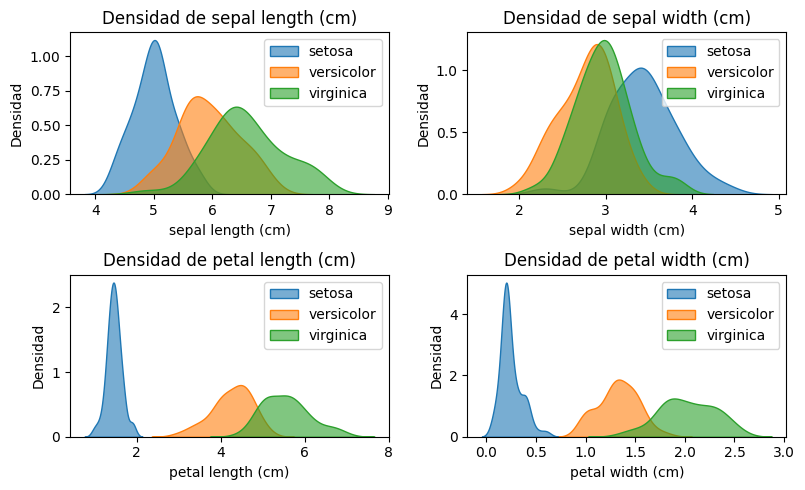

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_iris = pd.DataFrame(X_full, columns=load_iris().feature_names)
df_iris['species'] = y_full.flatten()
features = load_iris().feature_names
classes = df_iris['species'].unique()

plt.figure(figsize=(8, 5))

for i, feature in enumerate(features):
    plt.subplot(2, 2, i + 1)
    for cls in classes:
        subset = df_iris[df_iris['species'] == cls]
        sns.kdeplot(subset[feature], label=cls, fill=True, alpha=0.6)
    plt.title(f'Densidad de {feature}')
    plt.xlabel(feature)
    plt.ylabel('Densidad')
    plt.legend()

plt.tight_layout()
plt.show()

### 2. Entrenamiento dataset Penguin QDA con diferentes *a_priori*

In [ ]:
# culmen_length_mm, culmen_depth_mm, flipper_length_mm, body_mass_g
X_full_penguins, y_full_penguins = get_penguins()

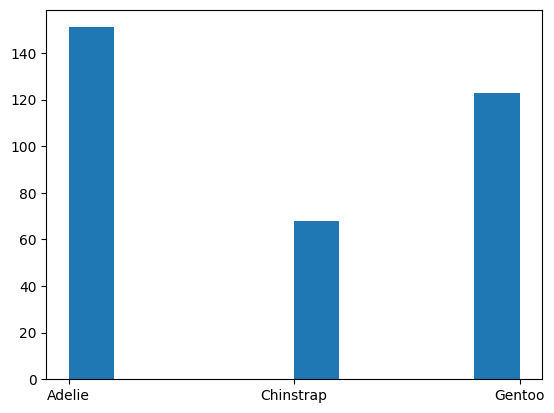

In [ ]:
import matplotlib.pyplot as plt

plt.hist(y_full_penguins)
plt.show()

In [ ]:
rng_seed = 123
train_x_penguins, train_y_penguins, test_x_penguins, test_y_penguins = split_transpose(X_full_penguins, y_full_penguins, 0.3, rng_seed)
a_prioris = [[1/3, 1/3, 1/3], [0.9, 0.05, 0.05], [0.05, 0.9, 0.05], [0.05, 0.05, 0.9]]
for i, a_priori in enumerate(a_prioris):
    qda = QDA()
    qda.fit(train_x_penguins, train_y_penguins, a_priori=a_priori)

    train_acc = accuracy(train_y_penguins, qda.predict(train_x_penguins))
    test_acc = accuracy(test_y_penguins, qda.predict(test_x_penguins))
    print(f"Using a_priori= {a_priori}")
    print(f"Train (apparent) error is {1-train_acc:.4f} while test error is {1-test_acc:.4f}")

Using a_priori= [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
Train (apparent) error is 0.0000 while test error is 0.0146
Using a_priori= [0.9, 0.05, 0.05]
Train (apparent) error is 0.0146 while test error is 0.0219
Using a_priori= [0.05, 0.9, 0.05]
Train (apparent) error is 0.0341 while test error is 0.0657
Using a_priori= [0.05, 0.05, 0.9]
Train (apparent) error is 0.0000 while test error is 0.0146


<center>

Modelo | Dataset | Seed | a_priori | Error (train) | Error (test)
:---: | :---: | :---: | :---: | :---: | :---:
QDA | Penguins | 123 | [1/3, 1/3, 1/3] | **0.0000** | **0.0146**
QDA | Penguins | 123 | [**0.9**, 0.05, 0.05] | 0.0146 | 0.0219
QDA | Penguins | 123 | [0.05, **0.9**, 0.05] | **0.0341** | **0.0657**
QDA | Penguins | 123 | [0.05, 0.05, **0.9**] | **0.0000** | **0.0146**

</center>

Se observa que la distribución que peor performa es la que asigna mayor probabilidad a la especie de pingüino *chinstrap* (\[0.05, **0.9**, 0.05\]). En el dataset original, es la especie con menor frecuencia.

La distribucion uniforme y la que asigna mayor probabilidad a la ultima clase son las que mejor performan.

### 3. Modelo LDA

* $\hat{\Sigma} = \frac{1}{n} \sum_{j=1}^k n_j \cdot s^2_j$ el promedio ponderado (por frecs. relativas) de las matrices de covarianzas de todas las clases. *Observar que se utiliza el estimador de MV y no el insesgado*

In [ ]:
class LDA(BaseBayesianClassifier):

  def _fit_params(self, X, y):
    # Each class covariance matrix (=QDA non inverted)
    covs = [np.cov(X[:,y.flatten()==idx], bias=True) for idx in range(len(self.log_a_priori))]
    # Inverted Weighted average (by frequency) of the covariance matrices of each class (covs).
    # Axis=0 to average across cov matrices not columns of same cov matrix.
    self.inv_cov = inv(np.average(covs, axis=0, weights=np.bincount(y.flatten().astype(int))))
    # Mean over axis=1, for each class go over the observations and get the mean for each feature
    # X shape = (features, observations). Axis = 0 iria por observacion y devolveria el promedio de las features
    self.means = [X[:,y.flatten()==idx].mean(axis=1, keepdims=True) for idx in range(len(self.log_a_priori))]

  def _predict_log_conditional(self, x, class_idx):
    unbiased_x =  x - self.means[class_idx]
    return 0.5*np.log(det(self.inv_cov)) -0.5 * unbiased_x.T @ self.inv_cov @ unbiased_x

Iris DS

In [ ]:
rng_seed = 333
train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.3, rng_seed)

qda = QDA()
qda.fit(train_x, train_y)

train_acc = accuracy(train_y, qda.predict(train_x))
test_acc = accuracy(test_y, qda.predict(test_x))
print(f"QDA -- Train (apparent) error is {1-train_acc:.4f} while test error is {1-test_acc:.4f}")

lda = LDA()
lda.fit(train_x, train_y)

train_acc = accuracy(train_y, lda.predict(train_x))
test_acc = accuracy(test_y, lda.predict(test_x))
print(f"LDA -- Train (apparent) error is {1-train_acc:.4f} while test error is {1-test_acc:.4f}")

QDA -- Train (apparent) error is 0.0111 while test error is 0.0333
LDA -- Train (apparent) error is 0.0111 while test error is 0.0500


<center>

Modelo | Dataset | Seed | Error (train) | Error (test)
:---: | :---: | :---: | :---: | :---:
QDA | Iris | 333 | **0.0111** | **0.0333**
LDA | Iris | 333 | 0.0111 | 0.0500

</center>

Penguin DS

In [ ]:
rng_seed = 333
X_full_penguins, y_full_penguins = get_penguins()
train_x_penguins, train_y_penguins, test_x_penguins, test_y_penguins = split_transpose(X_full_penguins, y_full_penguins, 0.3, rng_seed)

qda = QDA()
qda.fit(train_x_penguins, train_y_penguins)

train_acc = accuracy(train_y_penguins, qda.predict(train_x_penguins))
test_acc = accuracy(test_y_penguins, qda.predict(test_x_penguins))
print(f"QDA -- Train (apparent) error is {1-train_acc:.4f} while test error is {1-test_acc:.4f}")

lda = LDA()
lda.fit(train_x_penguins, train_y_penguins)

train_acc = accuracy(train_y_penguins, lda.predict(train_x_penguins))
test_acc = accuracy(test_y_penguins, lda.predict(test_x_penguins))
print(f"LDA -- Train (apparent) error is {1-train_acc:.4f} while test error is {1-test_acc:.4f}")

QDA -- Train (apparent) error is 0.0146 while test error is 0.0073
LDA -- Train (apparent) error is 0.0195 while test error is 0.0073


<center>

Modelo | Dataset | Seed | Error (train) | Error (test)
:---: | :---: | :---: | :---: | :---:
QDA | Penguins | 333 | **0.0146** | **0.0073**
LDA | Penguins | 333 | 0.0195 | 0.0073

</center>

Se observa un menor error con el modelo QDA para los dos datasets.

Generalizar con la media de las matrices de covarianza parece no ayudar en estos casos.

Tener la matriz de covarianza para cada clase da mejores resultados en ambos datasets.  

### 4. Random Seeds

In [ ]:
rng_seeds = [512, 831]

print("--- Iris DS ---")
for rng_seed in rng_seeds:
  train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.3, rng_seed)

  qda = QDA()
  qda.fit(train_x, train_y)

  train_acc = accuracy(train_y, qda.predict(train_x))
  test_acc = accuracy(test_y, qda.predict(test_x))
  print(f"QDA_{rng_seed} -- Train (apparent) error is {1-train_acc:.4f} while test error is {1-test_acc:.4f}")

  lda = LDA()
  lda.fit(train_x, train_y)

  train_acc = accuracy(train_y, lda.predict(train_x))
  test_acc = accuracy(test_y, lda.predict(test_x))
  print(f"LDA_{rng_seed} -- Train (apparent) error is {1-train_acc:.4f} while test error is {1-test_acc:.4f}")

print("--- Penguin DS ---")
for rng_seed in rng_seeds:
  X_full_penguins, y_full_penguins = get_penguins()
  train_x_penguins, train_y_penguins, test_x_penguins, test_y_penguins = split_transpose(X_full_penguins, y_full_penguins, 0.3, rng_seed)

  qda = QDA()
  qda.fit(train_x_penguins, train_y_penguins)

  train_acc = accuracy(train_y_penguins, qda.predict(train_x_penguins))
  test_acc = accuracy(test_y_penguins, qda.predict(test_x_penguins))
  print(f"QDA_PENGUIN_{rng_seed} -- Train (apparent) error is {1-train_acc:.4f} while test error is {1-test_acc:.4f}")

  lda = LDA()
  lda.fit(train_x_penguins, train_y_penguins)

  train_acc = accuracy(train_y_penguins, lda.predict(train_x_penguins))
  test_acc = accuracy(test_y_penguins, lda.predict(test_x_penguins))
  print(f"LDA_PENGUIN_{rng_seed} -- Train (apparent) error is {1-train_acc:.4f} while test error is {1-test_acc:.4f}")

--- Iris DS ---
QDA_512 -- Train (apparent) error is 0.0000 while test error is 0.0167
LDA_512 -- Train (apparent) error is 0.0222 while test error is 0.0167
QDA_831 -- Train (apparent) error is 0.0111 while test error is 0.0333
LDA_831 -- Train (apparent) error is 0.0222 while test error is 0.0667
--- Penguin DS ---
QDA_PENGUIN_512 -- Train (apparent) error is 0.0098 while test error is 0.0000
LDA_PENGUIN_512 -- Train (apparent) error is 0.0146 while test error is 0.0073
QDA_PENGUIN_831 -- Train (apparent) error is 0.0049 while test error is 0.0219
LDA_PENGUIN_831 -- Train (apparent) error is 0.0049 while test error is 0.0292


<center>

Modelo | Dataset | Seed | Error (train) | Error (test)
:---: | :---: | :---: | :---: | :---:
QDA | Iris | 512 | **0.0000** | **0.0167**
LDA | Iris | 512 | 0.0222 | 0.0167
QDA | Iris | 831 | **0.0111** | **0.0333**
LDA | Iris | 831 | 0.0222 | 0.0667

</center>

<center>

Modelo | Dataset | Seed | Error (train) | Error (test)
:---: | :---: | :---: | :---: | :---:
QDA | Penguin | 512 | **0.0098** | **0.0000**
LDA | Penguin | 512 | 0.0146 | 0.0073
QDA | Penguin | 831 | **0.0049** | **0.0219**
LDA | Penguin | 831 | 0.0049 | 0.0292

</center>

Probando con otros dos seeds randoms, las conclusiones previas se mantienen. Al utilizar otros dos valores de random seed (512 y 831), se observa que el modelo **QDA** sigue presentando un menor error en los conjuntos de prueba en comparación con **LDA** para ambos datasets (Iris y Penguin). Esto sugiere que QDA es más robusto frente a variaciones en la partición de los datos y que su superioridad en términos de precisión general es consistente, independientemente de la semilla utilizada para dividir los datos en conjuntos de entrenamiento y prueba.

### 5. Comparación QDA & TensorizedQDA

In [ ]:
rng_seed = 1234
train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.3, rng_seed)

qda = QDA()
qda.fit(train_x, train_y)

tensorized_qda = TensorizedQDA()
tensorized_qda.fit(train_x, train_y)

In [ ]:
%%timeit

qda.predict(train_x)

7.61 ms ± 554 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%%timeit

tensorized_qda.predict(train_x)

2.69 ms ± 249 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


**Resultados**

*   QDA 7.48 ms ± 977 µs
*   TensorizedQDA 2.51 ms ± 381 µs per loop

3 veces mas rapido

Esto se debe a que, en clase `TensorizedQDA` utilizando `np.stack` se apila en una nueva dimensión las matrices de covarianza inversas `self.inv_covs` y las medias `self.means`, esto crea un **tensor** de matrices y medias para todas las clases. Luego, se calculan las probabilidades condicionales para todas las clases usando ese tensor creado. En este caso vemos que al utilizar tensores presenta una gran eficiencia respecto a la  clase `QDA` en la cual el cálculo de probabilidad se realiza utilizando **compresión de listas** para cada clase por separado.

## Optimización matemática

**Sugerencia:** considerar combinaciones adecuadas de `transpose`, `reshape` y, ocasionalmente, `flatten`. Explorar la dimensionalidad de cada elemento antes de implementar las clases.

### QDA

Debido a la forma cuadrática de QDA, no se puede predecir para *n* observaciones en una sola pasada (utilizar $X \in \mathbb{R}^{p \times n}$ en vez de $x \in \mathbb{R}^p$) sin pasar por una matriz de *n x n* en donde se computan todas las interacciones entre observaciones. Se puede acceder al resultado recuperando sólo la diagonal de dicha matriz, pero resulta ineficiente en tiempo y (especialmente) en memoria. Aún así, es *posible* que el modelo funcione más rápido.

1. Implementar el modelo `FasterQDA` (se recomienda heredarlo de TensorizedQDA) de manera de eliminar el ciclo for en el método predict.
2. Comparar los tiempos de predicción de `FasterQDA` con `TensorizedQDA` y `QDA`.
3. Mostrar (puede ser con un print) dónde aparece la mencionada matriz de *n x n*, donde *n* es la cantidad de observaciones a predecir.
4.Demostrar que
$$
diag(A \cdot B) = \sum_{cols} A \odot B^T = np.sum(A \odot B^T, axis=1)
$$ es decir, que se puede "esquivar" la matriz de *n x n* usando matrices de *n x p*.
5.Utilizar la propiedad antes demostrada para reimplementar la predicción del modelo `FasterQDA` de forma eficiente. ¿Hay cambios en los tiempos de predicción?


### LDA

1. "Tensorizar" el modelo LDA y comparar sus tiempos de predicción con el modelo antes implementado. *Notar que, en modo tensorizado, se puede directamente precomputar $\mu^T \cdot \Sigma^{-1} \in \mathbb{R}^{k \times 1 \times p}$ y guardar eso en vez de $\Sigma^{-1}$.*
2. LDA no sufre del problema antes descrito de QDA debido a que no computa productos internos, por lo que no tiene un verdadero costo extra en memoria predecir "en batch". Implementar el modelo `FasterLDA` y comparar sus tiempos de predicción con las versiones anteriores de LDA.

### QDA

#### 1. FasterQDA

El objetivo fue eliminar el **bucle for** en el proceso de prediccion de la log condicional. En vez de iterar por cada observacion, se colocaron todas las observaciones en una misma matriz que, luego haberle restado el promedio (unbiased_X) y realizado el producto interno con la inversa de la matriz de covarianza, fue multiplicada nuevamente por la matriz unbiased_X e identificar los valores de la diagonal de la matriz resultante, es decir esta parte de la formula:

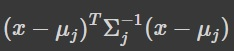

In [ ]:
class FasterQDA(TensorizedQDA):

    def _predict_log_conditionals(self, X):

        unbiased_X = X - self.tensor_means
        inv_cov = self.tensor_inv_cov

        #Calculamos la primera parte de la multiplicacion
        inner_dot = 0.5 * (unbiased_X.transpose(0,2,1) @ inv_cov @ unbiased_X)

        self.matrix_n_n = inner_dot
        #Obtenemos los valores de la diagonal del tensor (es decir aquellos valores donde se linkean las mismas observaciones)
        diagonal_obs = np.diagonal(inner_dot, axis1=1, axis2=2)

        # Calculamos el término logarítmico
        log_dets = (0.5 * np.log(det(self.tensor_inv_cov))).reshape(3,1)

        return log_dets - diagonal_obs

    def predict(self, X):
        log_posteriors = self.log_a_priori.reshape(3,1) + self._predict_log_conditionals(X)
        predictions = np.argmax(log_posteriors, axis=0)
        return self.encoder.names[predictions]


    def show_matrix(self):
        return f"La matriz tiene {self.matrix_n_n.shape[1]} filas y {self.matrix_n_n.shape[2]} columnas y se printea a continuacion:",self.matrix_n_n



In [ ]:
rng_seed = 1234
train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.3, rng_seed)

faster_qda = FasterQDA()
faster_qda.fit(train_x, train_y)

train_acc = accuracy(train_y, faster_qda.predict(train_x))
test_acc = accuracy(test_y, faster_qda.predict(test_x))
print(f"FASTER_QDA -- Train (apparent) error is {1-train_acc:.4f} while test error is {1-test_acc:.4f}")

FASTER_QDA -- Train (apparent) error is 0.0222 while test error is 0.0000


#### 2. FasterQDA vs TensorizedQDA vs QDA

In [ ]:
rng_seed = 1234
train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.3, rng_seed)

qda = QDA()
qda.fit(train_x, train_y)

tensorized_qda = TensorizedQDA()
tensorized_qda.fit(train_x, train_y)

faster_qda = FasterQDA()
faster_qda.fit(train_x, train_y)

In [ ]:
%%timeit

qda.predict(test_x)

6.52 ms ± 791 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%%timeit

tensorized_qda.predict(test_x)

1.89 ms ± 298 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
%%timeit

faster_qda.predict(test_x)

53 µs ± 980 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


<center>

Modelo | Mean Prediction Time (ms) | Std. dev (ms)
:---: | :---: | :---:
QDA | 5.98 | 0.39
TensorizedQDA | 1.79 | 0.219
**FasterQDA** | **0.0572** | **0.001**

</center>

Podemos observar que al eliminar el ciclo for, FasterQDA reduce la sobrecarga de controlar iteraciones individuales, que es más lenta en Python.

#### 3. Matriz n x n (60 para el caso de test_x)


In [ ]:
rng_seed = 1234
train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.3, rng_seed)

faster_qda = FasterQDA()
faster_qda.fit(train_x, train_y)
faster_qda.predict(test_x)
faster_qda.show_matrix()


('La matriz tiene 60 filas y 60 columnas y se printea a continuacion:',
 array([[[ 2.30387604e+02,  2.38620670e+02,  3.02063909e+02, ...,
           2.56396646e+02,  2.36015737e+02, -4.33013256e+00],
         [ 2.38620670e+02,  2.47270868e+02,  3.12658883e+02, ...,
           2.65914906e+02,  2.45061305e+02, -4.63012062e+00],
         [ 3.02063909e+02,  3.12658883e+02,  3.96583176e+02, ...,
           3.34671566e+02,  3.07681438e+02, -5.55428476e+00],
         ...,
         [ 2.56396646e+02,  2.65914906e+02,  3.34671566e+02, ...,
           2.90186422e+02,  2.67634367e+02, -4.77439894e+00],
         [ 2.36015737e+02,  2.45061305e+02,  3.07681438e+02, ...,
           2.67634367e+02,  2.47514579e+02, -4.76589860e+00],
         [-4.33013256e+00, -4.63012062e+00, -5.55428476e+00, ...,
          -4.77439894e+00, -4.76589860e+00,  3.62536481e-01]],
 
        [[ 6.40428263e-01,  7.39090776e-01,  1.20725004e+00, ...,
           5.72907044e-01,  5.50839524e-01, -1.38467386e+00],
         [ 7.39

#### Ejercicio 4: Demostración de la Propiedad

Demostrar que:
$$
\text{diag}(A \cdot B) = \sum_{\text{cols}} A \odot B^T = \text{np.sum}(A \odot B^T, \text{axis}=1)
$$
Es decir, demostrar que se puede "esquivar" la matriz de *n x n* usando matrices de *n x p*.

### Resolución

Consideremos lo siguiente:
- Sea $(A)$ una matriz de dimensiones $( n \times p )$ y $( B )$ una matriz de dimensiones $( p \times n )$.
- El producto $( A \cdot B )$ resulta en una matriz de dimensiones $( n \times n )$.

La ( i )-ésima diagonal del producto matricial $( A \cdot B )$ se puede expresar como:
$$
\text{diag}(A \cdot B)_i = \sum_{k=1}^{p} A_{ik} \cdot B_{ki}
$$
Esto es equivalente a sumar los productos de los elementos correspondientes en la fila ( i ) de $( A )$ y la columna ( i ) de $( B )$, que se corresponde con la operación de producto Hadamard.

Al realizar la operación Hadamard $( A \odot B^T )$, obtenemos una matriz $( C )$ de dimensiones $( n \times p )$, cuya suma sobre cada fila $(axis=1)$ da el mismo resultado que la diagonal de $( A \cdot B )$.

Por lo tanto, se tiene que:
$$
\text{diag}(A \cdot B)_i = \sum_{k=1}^{p} C_{ik} = \text{np.sum}(A \odot B^T, \text{axis}=1)_i
$$
Esto demuestra la equivalencia propuesta.

#### 5. Optimizacion FasterQDA

Ahora, utilizando esta propiedad, se puede optimizar la implementación del modelo `FasterQDA` para mejorar la eficiencia en la predicción.

In [ ]:
class FasterQDA(TensorizedQDA):
    def predict(self, X, verbose=False):
        m_obs = X.shape[1]
        y_hat = np.empty(m_obs, dtype=self.encoder.fmt)

        unbiased_X = X - self.tensor_means  # unbiased_X.shape = (3, 4, n)
        # Calcular el producto interno usando la propiedad demostrada
        inner_prod_diag = np.sum((self.tensor_inv_cov @ unbiased_X) * unbiased_X, axis=1)  # (3, n)

        if verbose:
            print(f"Debug -- Inner prod diagonal shape {inner_prod_diag.shape}")
            print(inner_prod_diag)

        log_a_priori_per_class = np.tile(self.log_a_priori, (X.shape[1], 1))  # (n, 3)
        log_det_inv_cov_per_class = np.tile(np.log(det(self.tensor_inv_cov)), (X.shape[1], 1))  # (n, 3)

        m_result = log_a_priori_per_class + (0.5 * log_det_inv_cov_per_class - 0.5 * inner_prod_diag.T)  # all (n, 3)

        # argmax to find class with higher result (column index for class with higher result)
        encoded_y_hat = np.argmax(m_result, axis=1)  # (n,) encoded classes
        y_hat[:len(encoded_y_hat)] = self.encoder.names[encoded_y_hat]
        return y_hat.reshape(1, -1)

In [ ]:
rng_seed = 1234
train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.3, rng_seed)

faster_qda = FasterQDA()
faster_qda.fit(train_x, train_y)

train_acc = accuracy(train_y, faster_qda.predict(train_x))
test_acc = accuracy(test_y, faster_qda.predict(test_x))

In [ ]:
rng_seed = 1234
train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.3, rng_seed)

# Este es el nuevo FasterQDA optimizado
faster_qda = FasterQDA()
faster_qda.fit(train_x, train_y)

In [ ]:
%%timeit

faster_qda.predict(train_x)

94.4 µs ± 20.5 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### LDA

#### 1. LDA Tensorizado


*Notar que, en modo tensorizado, se puede directamente precomputar $\mu^T \cdot \Sigma^{-1} \in \mathbb{R}^{k \times 1 \times p}$ y guardar eso en vez de $\Sigma^{-1}$.*

In [ ]:
class TensorizedLDA(LDA):

    def _fit_params(self, X, y):
        # ask plain LDA to fit params
        super()._fit_params(X,y)

        self.tensor_inv_cov = self.inv_cov
        self.tensor_means = np.stack(self.means)
        self.log_det_tensor_inv_cov = 0.5 * np.log(det(self.tensor_inv_cov))

    def _predict_log_conditionals(self,x):
        unbiased_x = x - self.tensor_means
        inner_prod = unbiased_x.transpose(0,2,1) @ self.tensor_inv_cov @ unbiased_x # (3, 1, 4) @ (4, 4) @ (3, 4, 1) => (3, 1, 4) @ (3, 4, 1) => (3, 1, 1)

        return self.log_det_tensor_inv_cov - 0.5 * inner_prod.flatten()

    def _predict_one(self, x):
        # return the class that has maximum a posteriori probability
        return np.argmax(self.log_a_priori + self._predict_log_conditionals(x))

In [ ]:
rng_seed = 1234
train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.3, rng_seed)

tensorized_lda = TensorizedLDA()
lda = LDA()
tensorized_lda.fit(train_x, train_y)
lda.fit(train_x, train_y)

train_acc = accuracy(train_y, tensorized_lda.predict(train_x))
test_acc = accuracy(test_y, tensorized_lda.predict(test_x))
print(f"TENSORIZED_LDA -- Train (apparent) error is {1-train_acc:.4f} while test error is {1-test_acc:.4f}")
train_acc = accuracy(train_y, lda.predict(train_x))
test_acc = accuracy(test_y, lda.predict(test_x))
print(f"LDA -- Train (apparent) error is {1-train_acc:.4f} while test error is {1-test_acc:.4f}")

TENSORIZED_LDA -- Train (apparent) error is 0.0222 while test error is 0.0167
LDA -- Train (apparent) error is 0.0222 while test error is 0.0167


#### 2. FasterLDA vs TensorizedLDA vs LDA

In [ ]:
class FasterLDA(TensorizedLDA):

    def _predict_log_conditionals(self, X):
        unbiased_X = X - self.tensor_means

        inner_dot = 0.5 * (unbiased_X.transpose(0, 2, 1) @ self.tensor_inv_cov @ unbiased_X)

        # Extrae la diagonal de los productos internos
        diagonal_obs = np.diagonal(inner_dot, axis1=1, axis2=2)

        log_det_term = self.log_det_tensor_inv_cov

        return log_det_term - diagonal_obs

    def predict(self, X):
        log_posteriors = self.log_a_priori.reshape(3, 1) + self._predict_log_conditionals(X)
        predictions = np.argmax(log_posteriors, axis=0)

        return self.encoder.names[predictions]

In [ ]:
rng_seed = 1234
train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.3, rng_seed)

faster_lda = FasterLDA()
faster_lda.fit(train_x, train_y)

train_acc = accuracy(train_y, faster_lda.predict(train_x))
test_acc = accuracy(test_y, faster_lda.predict(test_x))
print(f"FASTER_LDA -- Train (apparent) error is {1-train_acc:.4f} while test error is {1-test_acc:.4f}")

FASTER_LDA -- Train (apparent) error is 0.0222 while test error is 0.0167


In [ ]:
lda = LDA()
lda.fit(train_x, train_y)

tensorized_lda = TensorizedLDA()
tensorized_lda.fit(train_x, train_y)

faster_lda = FasterLDA()
faster_lda.fit(train_x, train_y)

In [ ]:
%%timeit

lda.predict(train_x)

7.58 ms ± 1.2 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%%timeit

tensorized_lda.predict(train_x)

1.87 ms ± 276 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
%%timeit

faster_lda.predict(train_x)

65.9 µs ± 13.1 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


<center>

Modelo | Mean Prediction Time (ms) | Std. dev (ms)
:---: | :---: | :---:
LDA | 8.15 | 1.5
TensorizedLDA | 1.88 | 297
**FasterLDA** | **65.9µs** | **13.1 µs**

</center>

## Preguntas teóricas

1. En LDA se menciona que la función a maximizar puede ser, mediante operaciones, convertida en:
$$
\log{f_j(x)} =  \mu_j^T \Sigma^{-1} (x- \frac{1}{2} \mu_j) + C'
$$
Mostrar los pasos por los cuales se llega a dicha expresión.
2. Explicar, utilizando las respectivas funciones a maximizar, por qué QDA y LDA son "quadratic" y "linear".
3. La implementación de QDA estima la probabilidad condicional utilizando `0.5*np.log(det(inv_cov)) -0.5 * unbiased_x.T @ inv_cov @ unbiased_x` que no es *exactamente* lo descrito en el apartado teórico ¿Cuáles son las diferencias y por qué son expresiones equivalentes?

El espíritu de esta componente práctica es la de establecer un mínimo de trabajo aceptable para su entrega; se invita al alumno a explorar otros aspectos que generen curiosidad, sin sentirse de ninguna manera limitado por la consigna.

---


### 1.

Por definición, se tiene que para una clase $j$:

$$
f_j(x) = \frac{1}{(2 \pi)^\frac{p}{2} \cdot |\Sigma|^\frac{1}{2}} e^{- \frac{1}{2}(x-\mu_j)^T \Sigma^{-1} (x- \mu_j)}
$$

*Pasos para llegar a la expresión de la función a maximizar de LDA*

**Aplicamos logaritmo natural de \(f_j(x)\)**:

   $$
   \log f_j(x) = \log \left( \frac{1}{(2\pi)^{p/2} |\Sigma|^{1/2}} \right) - \frac{1}{2} (x - \mu_j)^T \Sigma^{-1} (x - \mu_j)
   $$

**Descompocisión el logaritmo del primer término**:

   $$
   \log \left( \frac{1}{(2\pi)^{p/2} |\Sigma|^{1/2}} \right) = -\frac{p}{2} \log(2\pi) - \frac{1}{2} \log |\Sigma|
   $$

   Quedando:

   $$
   \log f_j(x) = -\frac{p}{2} \log(2\pi) - \frac{1}{2} \log |\Sigma| - \frac{1}{2} (x - \mu_j)^T \Sigma^{-1} (x - \mu_j)
   $$

**Simplificando**:

   Dado que el término $-\frac{p}{2} \log(2\pi)$ es constante para todas las clases, y el término $-\frac{1}{2}\log |\Sigma|$ es común a todas las clases en el caso de LDA, se pueden agrupar en una constante aditiva, C':

   $$
   \log f_j(x) = -\frac{1}{2} (x - \mu_j)^T \Sigma^{-1} (x - \mu_j) + C'
   $$

**Expanción del término cuadrático**:

   $$
   (x - \mu_j)^T \Sigma^{-1} (x - \mu_j) = x^T \Sigma^{-1} x - 2x^T \Sigma^{-1} \mu_j + \mu_j^T \Sigma^{-1} \mu_j
   $$

Sustituyendo:

   $$
   \log f_j(x) = -\frac{1}{2} \left( x^T \Sigma^{-1} x - 2x^T \Sigma^{-1} \mu_j + \mu_j^T \Sigma^{-1} \mu_j \right) + C'
   $$

**Distribución de $-\frac{1}{2}$**:

   $$
   \log f_j(x) = -\frac{1}{2} x^T \Sigma^{-1} x + x^T \Sigma^{-1} \mu_j - \frac{1}{2} \mu_j^T \Sigma^{-1} \mu_j + C'
   $$

**Simplificando**:


   $$
   \log f_j(x) = x^T \Sigma^{-1} \mu_j - \frac{1}{2} \mu_j^T \Sigma^{-1} \mu_j + C'
   $$

Como:
   $$
   x^T \Sigma^{-1} \mu_j = \mu_j^T \Sigma^{-1}x
   $$

Se llega la fórmula final:
   $$
   \log f_j(x) = \mu_j^T \Sigma^{-1} (x - \frac{1}{2} \mu_j) + C'
   $$

### 2.
_QDA_

El término `cuadrático` en el Análisis Discriminante Cuadrático (QDA) se refiere a la forma cuadrática de las fronteras de decisión que se generan para clasificar los datos en diferentes clases.

Dada la función a maximizar:
$$
\log{f_j(x)} = -\frac{1}{2}\log |\Sigma_j| - \frac{1}{2} (x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j) + C
$$

El término:
$$
(x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j)
$$

es una forma cuadrática en $x$, lo que significa que cuando se iguala a los discriminantes de dos clases para encontrar la frontera de decisión, se obtiene una ecuación cuadrática en $x$. Esto permite mayor flexibilidad en la clasificación,  sobre todo cuando las clases tienen diferentes estructuras de covarianza.

_LDA_

El término `lineal` en el Análisis Discriminante Lineal (LDA) se refiere a que las fronteras de decisión que se generan para clasificar los datos en diferentes clases son hiperplanos, es decir, superficies de separación lineales.

Dada la función a maximizar:
$$
\log{f_j(x)} =  \mu_j^T \Sigma^{-1} (x- \frac{1}{2} \mu_j) + C'
$$

El término:
$$
 \mu_j^T \Sigma^{-1} x
$$
es una combinación lineal de las características $x$.


### 3.

Fórmula _QDA_:

$$
\log{f_j(x)} = -\frac{1}{2}\log |\Sigma_j| - \frac{1}{2} (x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j) + C
$$

Código:

`0.5*np.log(det(inv_cov)) -0.5 * unbiased_x.T @ inv_cov @ unbiased_x`

**Primer término**

$$
-\frac{1}{2}\log |\Sigma_j| = 0.5 \cdot \text{np.log(det(inv_cov))}
$$


> Relación: existe una propiedad del determinante que dice que, si se tiene el determinante de la matriz de covarianza inversa, su logaritmo es el negativo del logaritmo del determinante de la matriz de covarianza original Σ𝑗.


**Segundo término**

<center>

Fórmula matemática |  Código
:---: | :---:
 𝑥−𝜇𝑗  |  unbiased_x = x - self.means[class_idx]
$(x-\mu_j)^T$ | unbiased_x.T
$\Sigma_j^{-1}$ |  inv_cov = self.inv_covs[class_idx]
-1/2​ | −0.5
$(x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j)$ | unbiased_x.T @ inv_cov @ unbiased_x

</center>

> Con respecto al producto matricial, el código correspondiente realiza el mismo cálculo que la fórmula matemática utilizando operaciones matriciales de NumPy.

**Tercer término**

> La constante $C$ se omite en el cálculo de la probabilidad condicional, ya que  no afecta la comparación de clases al predecir la clase más probable.


## Ejercicio teórico

Sea una red neuronal de dos capas, la primera de 3 neuronas y la segunda de 1 con los parámetros inicializados con los siguientes valores:
$$
w^{(1)} =
\begin{pmatrix}
0.1 & -0.5 \\
-0.3 & -0.9 \\
0.8 & 0.02
\end{pmatrix},
b^{(1)} = \begin{pmatrix}
0.1 \\
0.5 \\
0.8
\end{pmatrix},
w^{(2)} =
\begin{pmatrix}
-0.4 & 0.2 & -0.5
\end{pmatrix},
b^{(2)} = 0.7
$$

y donde cada capa calcula su salida vía

$$
y^{(i)} = \sigma (w^{(i)} \cdot x^{(i)}+b^{(i)})
$$

donde $\sigma (z) = \frac{1}{1+e^{-z}}$ es la función sigmoidea .

\\
Dada la observación $x=\begin{pmatrix}
1.8 \\
-3.4
\end{pmatrix}$, $y=5$ y la función de costo $J(\theta)=\frac{1}{2}(\hat{y}_\theta-y)^2$, calcular las derivadas de J respecto de cada parámetro $w^{(1)}$, $w^{(2)}$, $b^{(1)}$, $b^{(2)}$.

*Nota: Con una sigmoidea a la salida jamás va a poder estimar el 5 "pedido", pero eso no afecta al mecanismo de backpropagation!*

### Resolución

#### 1. **Forward Pass**

Primero, realizamos el "forward pass" para calcular la salida de la red.

- **Capa 1**:
  
  $$
  z^{(1)} = w^{(1)} \cdot x + b^{(1)} =
  \begin{pmatrix}
  0.1 & -0.5 \\
  -0.3 & -0.9 \\
  0.8 & 0.02
  \end{pmatrix}
  \begin{pmatrix}
  1.8 \\
  -3.4
  \end{pmatrix}
  +
  \begin{pmatrix}
  0.1 \\
  0.5 \\
  0.8
  \end{pmatrix}
  $$

  Calculamos $ z^{(1)} $:

  $$
  z^{(1)} =
  \begin{pmatrix}
  0.1 \times 1.8 + (-0.5) \times (-3.4) + 0.1 \\
  -0.3 \times 1.8 + (-0.9) \times (-3.4) + 0.5 \\
  0.8 \times 1.8 + 0.02 \times (-3.4) + 0.8
  \end{pmatrix}
  =
  \begin{pmatrix}
  2.0 \\
  3.88 \\
  2.984
  \end{pmatrix}
  $$

  Aplicamos la función sigmoidea:

  $$
  a^{(1)} = \sigma(z^{(1)}) =
  \begin{pmatrix}
  \sigma(2.0) \\
  \sigma(3.88) \\
  \sigma(2.984)
  \end{pmatrix}
  =
  \begin{pmatrix}
  0.8808 \\
  0.9798 \\
  0.9518
  \end{pmatrix}
  $$

- **Capa 2**:

  $$
  z^{(2)} = w^{(2)} \cdot a^{(1)} + b^{(2)} =
  \begin{pmatrix}
  -0.4 & 0.2 & -0.5
  \end{pmatrix}
  \begin{pmatrix}
  0.8808 \\
  0.9798 \\
  0.9518
  \end{pmatrix}
  + 0.7
  $$

  Calculamos $ z^{(2)} $:

  $$
  z^{(2)} =
  -0.4 \times 0.8808 + 0.2 \times 0.9798 - 0.5 \times 0.9518 + 0.7 = -0.3523 + 0.19596 - 0.4759 + 0.7 = 0.06776
  $$

  Aplicamos la función sigmoidea para obtener la predicción $( \hat{y} )$:

  $$
  \hat{y} = \sigma(z^{(2)}) = \sigma(0.06776) = 0.5169
  $$

#### 2. **Backward Pass (Cálculo de Gradientes)**

Ahora calculamos las derivadas de la función de costo $( J(\theta) )$ con respecto a los parámetros usando backpropagation.

- **Capa 2**:

  $$
  \frac{\partial J}{\partial z^{(2)}} = \hat{y} - y = 0.5169 - 5 = -4.4831
  $$

  - Derivada respecto a $ w^{(2)} $:
  
  $$
  \frac{\partial J}{\partial w^{(2)}} = \frac{\partial J}{\partial z^{(2)}} \cdot \frac{\partial z^{(2)}}{\partial w^{(2)}} = -4.4831 \cdot a^{(1)} =
  \begin{pmatrix}
  -4.4831 \times 0.8808 \\
  -4.4831 \times 0.9798 \\
  -4.4831 \times 0.9518
  \end{pmatrix}
    =
  \begin{pmatrix}
  -3.948 \\
  -4.391 \\
  -4.267
  \end{pmatrix}
  $$

  - Derivada respecto a $ b^{(2)} $:

  $$
  \frac{\partial J}{\partial b^{(2)}} = \frac{\partial J}{\partial z^{(2)}} = -4.4831
   $$

- **Capa 1**:

  Calculamos primero $ \frac{\partial J}{\partial a^{(1)}} $ y luego $ \frac{\partial J}{\partial z^{(1)}} $:

  $$
  \frac{\partial J}{\partial a^{(1)}} = \frac{\partial J}{\partial z^{(2)}} \cdot w^{(2)} =
  -4.4831 \cdot
  \begin{pmatrix}
  -0.4 \\
  0.2 \\
  -0.5
  \end{pmatrix}
  =
  \begin{pmatrix}
  1.7932 \\
  -0.8966 \\
  2.24155
  \end{pmatrix}
  $$

  Luego, usamos la derivada de la función sigmoidea:

  $$
  \frac{\partial J}{\partial z^{(1)}} = \frac{\partial J}{\partial a^{(1)}} \cdot \sigma'(z^{(1)}) =
  \frac{\partial J}{\partial a^{(1)}} \cdot a^{(1)} \cdot (1 - a^{(1)})
  $$

  Calculamos $ \sigma'(z^{(1)}) $:

  $$
  \sigma'(z^{(1)}) =
  \begin{pmatrix}
  0.8808 \times (1 - 0.8808) \\
  0.9798 \times (1 - 0.9798) \\
  0.9518 \times (1 - 0.9518)
  \end{pmatrix}
  =
  \begin{pmatrix}
  0.1048 \\
  0.0197 \\
  0.0459
  \end{pmatrix}
  $$

  Multiplicamos para obtener $ \frac{\partial J}{\partial z^{(1)}} $:

  $$
  \frac{\partial J}{\partial z^{(1)}} =
  \begin{pmatrix}
  1.7932 \times 0.1048 \\
  -0.8966 \times 0.0197 \\
  2.24155 \times 0.0459
  \end{pmatrix}
  =
  \begin{pmatrix}
  0.1879 \\
  -0.0177 \\
  0.1029
  \end{pmatrix}
  $$

  - Derivadas respecto a $ w^{(1)} $:

  $$
  \frac{\partial J}{\partial w^{(1)}} = \frac{\partial J}{\partial z^{(1)}} \cdot x^T =
  \begin{pmatrix}
  0.1879 \times 1.8 & 0.1879 \times -3.4 \\
  -0.0177 \times 1.8 & -0.0177 \times -3.4 \\
  0.1029 \times 1.8 & 0.1029 \times -3.4
  \end{pmatrix}
    =
  \begin{pmatrix}
  0.3383 & -0.6389 \\
  -0.0319 & 0.06018 \\
  0.1852 & -0.350
  \end{pmatrix}
  $$

  - Derivadas respecto a $ b^{(1)} $:

  $$
  \frac{\partial J}{\partial b^{(1)}} = \frac{\partial J}{\partial z^{(1)}} =
  \begin{pmatrix}
  0.1879 \\
  -0.0177 \\
  0.1029
  \end{pmatrix}
  $$

### Resumen de Gradientes

- $ \frac{\partial J}{\partial w^{(1)}} $:

  $$
  \begin{pmatrix}
  0.3383 & -0.6389 \\
  -0.0319 & 0.06018 \\
  0.1852 & -0.350
  \end{pmatrix}
  $$

- $ \frac{\partial J}{\partial b^{(1)}} $:

  $$
  \begin{pmatrix}
  0.1879 \\
  -0.0177 \\
  0.1029
  \end{pmatrix}
  $$

- $ \frac{\partial J}{\partial w^{(2)}} $:

  $$
  \begin{pmatrix}
  -3.948 \\
  -4.391 \\
  -4.267
  \end{pmatrix}
  $$

- $ \frac{\partial J}{\partial b^{(2)}} = -4.4831 $


## Preguntas en el código
Previamente las preguntas "técnicas" en comentarios en el código eran parte del TP, y buscaban que el alumno logre entrar en el detalle de por qué cada linea de código es como es y en el orden en el que está. Ya no forman parte de la consigna, pero se aconseja al alumno intentar responderlas. Las respuestas a las mismas se encuentran en un archivo separado.